In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks

os.chdir('./CycleSR/')

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [2]:
!pip install --upgrade pip
!pip uninstall scikit-image
!pip install scikit-image
import skimage
print(skimage.__version__)
# skimage 0.19.0 is compulsory

     |████████████████████████████████| 1.7 MB 5.1 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Found existing installation: scikit-image 0.18.3
Uninstalling scikit-image-0.18.3:
  Would remove:
    /usr/local/bin/skivi
    /usr/local/lib/python3.7/dist-packages/scikit_image-0.18.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/scikit_image.libs/libgomp-3300acd3.so.1.0.0
    /usr/local/lib/python3.7/dist-packages/skimage/*
Proceed (Y/n)? y
  Successfully uninstalled scikit-image-0.18.3
     |████████████████████████████████| 13.3 MB 5.0 MB/s            
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
0.19.1


In [3]:
%cd ./pytorch_wavelets/
!pip install .
%cd ../

/content/drive/MyDrive/Colab Notebooks/CycleSR/pytorch_wavelets
Processing /content/drive/MyDrive/Colab Notebooks/CycleSR/pytorch_wavelets
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-wavelets: filename=pytorch_wavelets-1.3.0-py3-none-any.whl size=55125 sha256=ed0a63f713757baf880c81a03cacc9a9a7a46eda884c9054f6a5695a1c713bb2
  Stored in directory: /tmp/pip-ephem-wheel-cache-4f8s87y2/wheels/c2/68/5e/51fa73a99f70fdfe25ce12e2bc3c4ece9a0b825a1a53184fe5
Successfully built pytorch-wavelets
/content/drive/MyDrive/Colab Notebooks/CycleSR


In [4]:
!python train.py --decay_epoch 25 --pretrained False --n_epochs 50 --lr 2e-4

Namespace(batchSize=1, cuda=False, dataroot='./dataset/Colab_random_OCTA_augmented', decay_epoch=25, epoch=0, input_nc=1, lr=0.0002, n_cpu=2, n_epochs=50, output_nc=1, pretrained=True, pretrained_root='./pre_trained/netG_A2B_pretrained.pth', sizeA=128, sizeB=256)
# FS type: gau, kernel size=5
# FS type: gau, kernel size=5
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
354
[W Copy.cpp:244] Warning: Casting complex values to real discards the imaginary part (function operator())
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch (1/50) Finished
100% 297/297 [02:46<00:00,  1.79it/s]
 PSNR: 16.2376 SSIM: 0.4095 MSE: 0.0960 NMI: 1.0488
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch (2/50) Finished
100% 297/297 [00:25<00:00, 11.75it/s]
 PSNR: 17.1344 SSIM: 0.4277 MSE: 0.0782 NMI: 1.0541
Adjusting learning rate of group 0 to 2.0

In [4]:
from model import UnetGeneratorA2B
import torch
import glob
import random
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [5]:
from baseline import ResnetGenerator, UnetGenerator
from utils import eval

In [6]:
netG_A2B = UnetGeneratorA2B(1, 1).cuda()
model = torch.load("./pre_trained/netG_A2B_pretrained.pth")
netG_A2B.load_state_dict(model, strict=False)
eval(netG_A2B)

100%|██████████| 297/297 [02:39<00:00,  1.86it/s]

 PSNR: 17.0013 SSIM: 0.4063 MSE: 0.0807 NMI: 1.0509


Test Set Evaluation

In [43]:
class Test_ImageDataset(Dataset):
    def __init__(self, root, transforms_test=None, unaligned=False, mode='test'):
        self.transformA = transforms.Compose(transforms_test)
        self.transformB = transforms.Compose(transforms_test)

        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, '6x6_256/') + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '3x3_256/') + '/*.*'))

    def __getitem__(self, index):
        img_A = Image.open(self.files_A[index % len(self.files_A)]).convert('L')
        # print(self.files_A[index % len(self.files_A)])
        item_A = self.transformA(img_A)

        item_B = self.transformB(Image.open("./dataset/test/3x3_256/102_6.png").convert('L'))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

test_path = "./dataset/test/"
transforms_test = [ 
                transforms.ToTensor(),
                # transforms.Normalize((0.246), (0.170)),
                transforms.Normalize((0.5), (0.5)) ]
test_dataset = Test_ImageDataset(test_path, transforms_test=transforms_test, unaligned=True)

In [44]:
img = test_dataset[2]['A']
gt = test_dataset[2]['B']
# print(img.shape)
img = cv2.resize(img.squeeze(0).cpu().numpy(), dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
x = torch.tensor(img).unsqueeze(0).unsqueeze(0).cuda()


netG_A2B = UnetGeneratorA2B(1, 1).cuda()
model = torch.load("./output_exp/netG_A2B_epoch43.pth")
# model = torch.load("./pre_trained/netG_A2B_pretrained.pth")
netG_A2B.load_state_dict(model, strict=False)
_, _, y = netG_A2B(x)

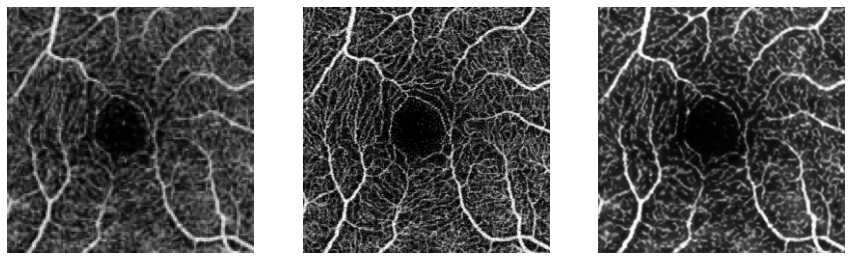

In [45]:
plt.figure(figsize=(15, 15))
plt.subplot(131), plt.imshow(img, "gray")
plt.axis('off')
plt.subplot(132),plt.imshow(gt.squeeze(0), "gray")
plt.axis('off')
yimg = y.cpu().detach().numpy().squeeze(0).squeeze(0)
plt.subplot(133), plt.imshow(yimg, "gray")
plt.axis('off')

ours_whole = yimg

(-0.5, 255.5, 255.5, -0.5)

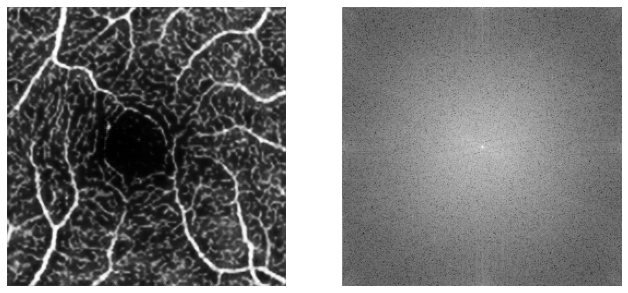

In [46]:
f = np.fft.fft2(yimg, axes=(-2, -1))
fshift = np.fft.fftshift(f)
res = np.log(np.abs(fshift))
pha = np.angle(fshift)
plt.figure(figsize=(11, 11))
plt.subplot(121), plt.imshow(yimg, 'gray')
plt.axis('off')
plt.subplot(122), plt.imshow(res, 'gray')
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

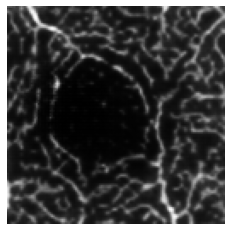

In [47]:
# plt.figure(figsize=(5, 5))
ours_faz = yimg[64:192, 64:192]
plt.imshow(ours_faz, "gray")
plt.axis('off')

Baseline Result Evaluation

In [48]:
########## ResNet Baseline ################

In [49]:
netG_A2B = torch.load('./baseline_output_resnet/netG_A2B_epoch100.pth')
type(netG_A2B)
model = ResnetGenerator(1, 1).cuda()
model.load_state_dict(netG_A2B, strict=False)

<All keys matched successfully>

In [50]:
img = test_dataset[2]['A']
gt = test_dataset[2]['B']
x = torch.tensor(img).unsqueeze(0).cuda()
y = model(x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


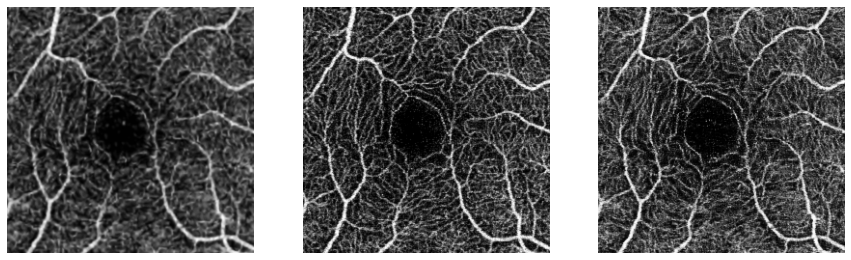

In [51]:
plt.figure(figsize=(15, 15))
plt.subplot(131), plt.imshow(img.squeeze(0), "gray")
plt.axis('off')
plt.subplot(132),plt.imshow(gt.squeeze(0), "gray")
plt.axis('off')
yimg = y.cpu().detach().numpy().squeeze(0).squeeze(0)
plt.subplot(133), plt.imshow(yimg, "gray")
plt.axis('off')

resnet_whole = yimg

(-0.5, 255.5, 255.5, -0.5)

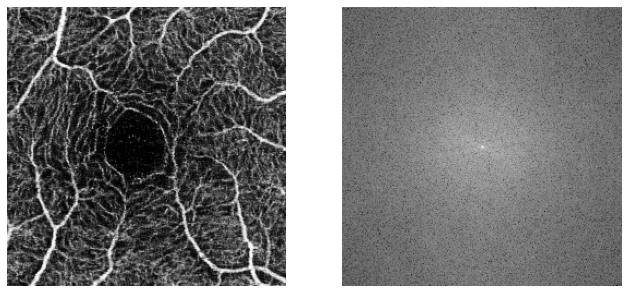

In [52]:
f = np.fft.fft2(yimg, axes=(-2, -1))
fshift = np.fft.fftshift(f)
res = np.log(np.abs(fshift))
pha = np.angle(fshift)
plt.figure(figsize=(11, 11))
plt.subplot(121), plt.imshow(yimg, 'gray')
plt.axis('off')
plt.subplot(122), plt.imshow(res, 'gray')
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

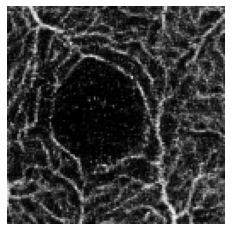

In [53]:
resnet_faz = yimg[64:192, 64:192]
plt.imshow(resnet_faz, "gray")
plt.axis('off')

In [54]:
########## UNet Baseline ################

In [55]:
netG_A2B = torch.load('./baseline_output_unet/netG_A2B_epoch100.pth')
type(netG_A2B)
model = UnetGenerator(1, 1).cuda()
model.load_state_dict(netG_A2B, strict=False)

<All keys matched successfully>

In [56]:
img = test_dataset[2]['A']
gt = test_dataset[2]['B']
x = torch.tensor(img).unsqueeze(0).cuda()
y = model(x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


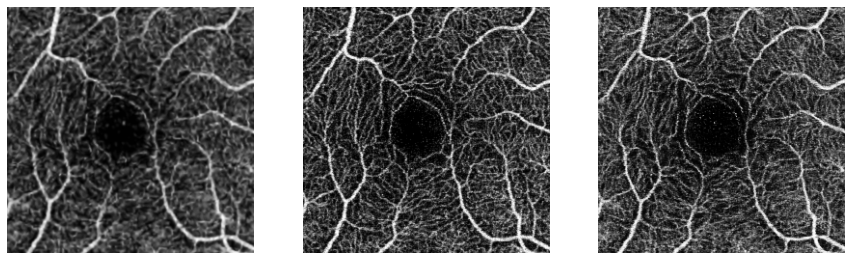

In [57]:
plt.figure(figsize=(15, 15))
plt.subplot(131), plt.imshow(img.squeeze(0), "gray")
lr_raw_img = img.squeeze(0)
plt.axis('off')
plt.subplot(132),plt.imshow(gt.squeeze(0), "gray")
hr_gt = gt.squeeze(0)
plt.axis('off')
yimg = y.cpu().detach().numpy().squeeze(0).squeeze(0)
plt.subplot(133), plt.imshow(yimg, "gray")
plt.axis('off')

unet_whole = yimg

(-0.5, 255.5, 255.5, -0.5)

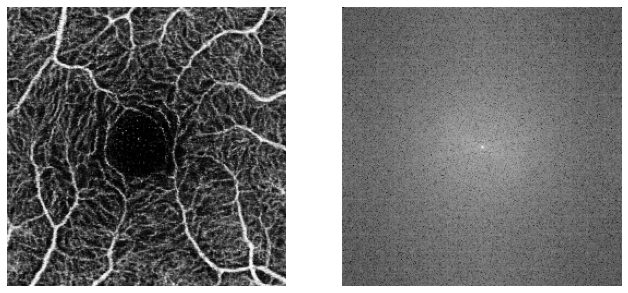

In [58]:
f = np.fft.fft2(yimg, axes=(-2, -1))
fshift = np.fft.fftshift(f)
res = np.log(np.abs(fshift))
pha = np.angle(fshift)
plt.figure(figsize=(11, 11))
plt.subplot(121), plt.imshow(yimg, 'gray')
plt.axis('off')
plt.subplot(122), plt.imshow(res, 'gray')
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

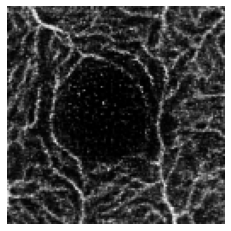

In [59]:
unet_faz = yimg[64:192, 64:192]
plt.imshow(unet_faz, "gray")
plt.axis('off')

Comparison

(-0.5, 127.5, 127.5, -0.5)

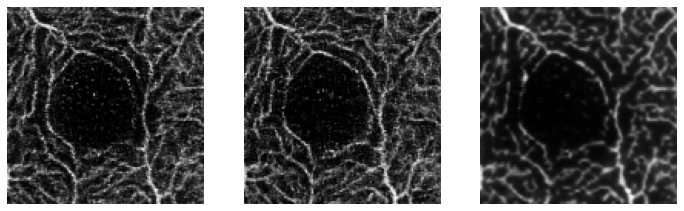

In [60]:
plt.figure(figsize=(12, 12))
plt.subplot(131), plt.imshow(unet_faz, "gray")
plt.axis('off')
plt.subplot(132),plt.imshow(resnet_faz, "gray")
plt.axis('off')
plt.subplot(133), plt.imshow(ours_faz, "gray")
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

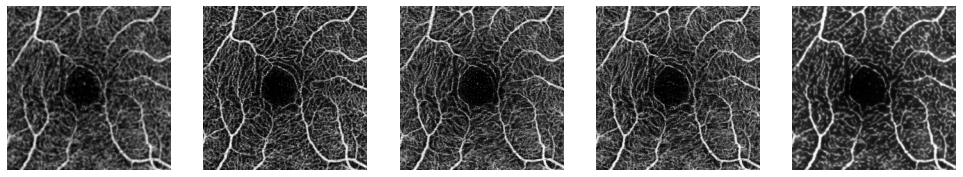

In [61]:
plt.figure(figsize=(17, 17))
plt.subplot(151), plt.imshow(lr_raw_img, "gray")
plt.axis('off')
plt.subplot(152),plt.imshow(hr_gt, "gray")
plt.axis('off')
plt.subplot(153), plt.imshow(unet_whole, "gray")
plt.axis('off')
plt.subplot(154),plt.imshow(resnet_whole, "gray")
plt.axis('off')
plt.subplot(155), plt.imshow(ours_whole, "gray")
plt.axis('off')

Todo: 6x6-mm whole LR-HR results evaluation

In [62]:
class ImageDataset_6mm(Dataset):
    def __init__(self, root, transforms_A=None, transforms_B=None, unaligned=False, mode='train'):
        self.transformA = transforms.Compose(transforms_A)
        self.transformB = transforms.Compose(transforms_B)

        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(root + '/*.*'))
        self.files_B = sorted(glob.glob(root + '/*.*'))

    def __getitem__(self, index):
        path_A = self.files_A[index % len(self.files_A)]
        img_A = Image.open(path_A).convert('L')
        item_A = self.transformA(img_A)

        if self.unaligned:
            item_B = self.transformB(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]).convert('L'))
        else:
            path_B = path_A.replace("hr", "lr")
            item_B = self.transformB(Image.open(path_B).convert('L'))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

test_path = "./dataset/evalution_6mm/parts"
transforms_A = [ 
                transforms.ToTensor(),
                # transforms.Normalize((0.246), (0.170)),
                transforms.Normalize((0.5), (0.5)), 
                transforms.CenterCrop(256),
                transforms.Resize((128, 128))
                ]
transforms_B = [ 
                transforms.ToTensor(),
                # transforms.Normalize((0.246), (0.170)),
                transforms.Normalize((0.5), (0.5)),
                transforms.CenterCrop(256)]
test_dataset = ImageDataset_6mm(test_path, transforms_A=transforms_A, transforms_B=transforms_B, unaligned=False)

In [63]:
img = test_dataset[0]['A']
gt = test_dataset[0]['B']
# print(img.shape)
img = cv2.resize(img.squeeze(0).cpu().numpy(), dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
x = torch.tensor(img).unsqueeze(0).unsqueeze(0).cuda()


netG_A2B = UnetGeneratorA2B(1, 1).cuda()
model = torch.load("./output_exp/netG_A2B_epoch39.pth")
# model = torch.load("./pre_trained/netG_A2B_pretrained.pth")
netG_A2B.load_state_dict(model, strict=False)
_, _, y = netG_A2B(x)

torch.Size([256, 256])


(-0.5, 255.5, 255.5, -0.5)

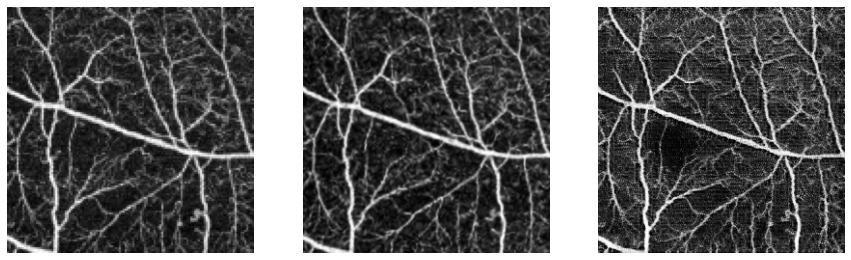

In [64]:
plt.figure(figsize=(15, 15))
plt.subplot(131), plt.imshow(img, "gray")
print(gt.squeeze(0).shape)
plt.axis('off')
plt.subplot(132),plt.imshow(gt.squeeze(0), "gray")
plt.axis('off')
yimg = y.cpu().detach().numpy().squeeze(0).squeeze(0)
plt.subplot(133), plt.imshow(yimg, "gray")
plt.axis('off')

In [65]:
yimg = y.cpu().detach().numpy().squeeze(0).squeeze(0)
gtimg = gt.cpu().detach().numpy().squeeze(0)
# print(yimg.shape, gtimg.shape)
psnr = (skimage.metrics.peak_signal_noise_ratio(yimg, gtimg))
ssim = (skimage.metrics.structural_similarity(yimg, gtimg))
mse = (skimage.metrics.mean_squared_error(yimg, gtimg))
nmi = (skimage.metrics.normalized_mutual_information(yimg, gtimg))
print(" PSNR: %.4f SSIM: %.4f MSE: %.4f NMI: %.4f"%(psnr, ssim, mse, nmi))

 PSNR: 17.7038 SSIM: 0.4405 MSE: 0.0679 NMI: 1.0531
